In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from general_IO import read_column

## Utility functions

In [2]:
def ByteToMegaByte(_bytes):
    return _bytes / (1024*1024)

def NanoToMilli(_ns):
    return _ns / 1000000

<Axes: title={'center': 'Sample Plot'}, xlabel='X-axis', ylabel='Y-axis'>

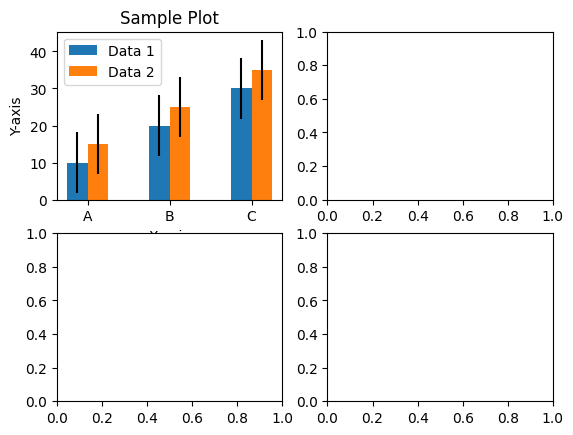

In [3]:
def plot_multibar(_ax, x_coordinates, x_labels, data_arrays, std_arrays, _plotTitle="", _plotXLabel="", _plotYLabel="", _dataLabels=[]):
    """
    Plot multiple bar charts.

    Parameters:
    - _ax (matplotlib.axes.Axes): The axes object to plot the data on.
    - x_coordinates (list): The x-coordinates of the bars.
    - x_labels (list): The labels for the x-axis.
    - data_arrays (list): The data arrays to be plotted.
    - _plotTitle (str): The title of the plot (optional).
    - _plotXLabel (str): The label for the x-axis (optional).
    - _plotYLabel (str): The label for the y-axis (optional).
    - _dataLabels (list): The labels for each data array (optional).

    Returns:
    - fig (matplotlib.figure.Figure): The figure object.
    - ax (matplotlib.axes.Axes): The axes object.
    """
    # Set the width of the bars
    bar_width = max(x_coordinates) / (len(x_coordinates) * 2)

    # Adjust the x-axis positions for the bars
    x_positions = np.array(x_coordinates) - bar_width/2
    x_ticks = np.zeros(len(x_coordinates))

    # Calculate the number of data arrays
    num_data_arrays = len(data_arrays)

    # Calculate the bar width for each data array
    bar_width_per_array = bar_width / num_data_arrays

    # Plotting
    for i, data_array in enumerate(data_arrays):
        # Adjust the x-axis positions for each data array
        x_positions_i = x_positions + i * bar_width_per_array
        x_ticks += x_positions_i/num_data_arrays

        # Plot the data array
        if (_dataLabels == []):
            _ax.bar(x_positions_i, data_array, width=bar_width_per_array, yerr = std_arrays[i])
        else:
            _ax.bar(x_positions_i, data_array, width=bar_width_per_array, label=_dataLabels[i], yerr = std_arrays[i])

    # Customize the plot
    _ax.set_xlabel(_plotXLabel)
    _ax.set_ylabel(_plotYLabel)
    _ax.set_title(_plotTitle)
    _ax.legend()

    # Set the x tick labels
    _ax.set_xticks(x_ticks)
    _ax.set_xticklabels(x_labels)

    return _ax

# Sample data
fig, ax = plt.subplots(2,2)
x_coordinates = [1, 2, 3]
data1 = [10, 20, 30]
data2 = [15, 25, 35]
x_labels = ['A', 'B', 'C']

# Call the function
plot_multibar(ax[0,0], x_coordinates, x_labels, [data1, data2], [np.std(data1), np.std(data2)], _plotTitle="Sample Plot", _plotXLabel="X-axis", _plotYLabel="Y-axis", _dataLabels=["Data 1", "Data 2"])


## Config parameters

In [37]:
numThreadUsedForGen = 4 #Number of threads used to generate the files
nbRepeats=100 #Number of time we run the writing process
nbRefs=[10, 100, 1000]#, 10000] #Number of objects for which we will override the translation, rotation, and scale.
nbBatch=[1, 2, 5, 10] #number of files in which the objects are going to be dispatched.
usdExtension = ["usda", "usdc"] #whether we use usda or usdc
totalBytesWritten=[3*3*4*_nbRefs for _nbRefs in nbRefs] #Size of the file in bytes

## Load all data 

In [38]:
dataFolder="./RuntimeResults_{}-Threads".format(numThreadUsedForGen)

allData = {}
allHeaders = {}
averageTimingsMs = {}
stdTimingsMs = {}

totalTimingsMs = {}
totalAverageTimingsMs = {}
totalStdTimingsMs = {}

for _nbRefs in nbRefs:
    for _nbBatch in nbBatch:
        for _usdExtension in usdExtension:

            _totalBytesWritten=3*3*4*_nbRefs
            key=(_totalBytesWritten, _nbRefs, _nbBatch, _usdExtension)
            filename = "{}_bytes_for_{}_objects_in_{}_{}_files.csv".format(_totalBytesWritten, _nbRefs, _nbBatch, _usdExtension)

            # Read the data
            timingsSTR = read_column(dataFolder, filename, [1,2,3,4], ",")
            timingsSTRSplit = [timing.split() for timing in timingsSTR[1:]]
            timingsNs = np.array(timingsSTRSplit).astype(np.int64)

            timingsHeaders = timingsNames=["UsdCreate", "Define World", "Add {} Refs\nto {} File(s)".format(_nbRefs, _nbBatch), "Save {} File".format(_nbBatch)]
            
            # Save the data
            allData[key] = timingsNs
            allHeaders[key] = timingsHeaders

            # Average and STD to milliseconds for the current key
            timings_ms = NanoToMilli(allData[key])
            averageTimingsMs[key] = np.mean(timings_ms, axis = 0)
            stdTimingsMs[key] = np.std(timings_ms, axis = 0)
            totalTimingsMs[key] = np.sum(timings_ms, axis = 1)
            totalAverageTimingsMs[key] = np.mean(totalTimingsMs[key])
            totalStdTimingsMs[key] = np.std(totalTimingsMs[key])


## Compare USDA and USDC files

### Show timings in milliseconds for each of the "4 parts" of the writing procedure

See the function WriteUSDStage in `./WriteUSDStageProfiling.py` for the "4 parts"

The following is a demonstration of what we will be ploting:

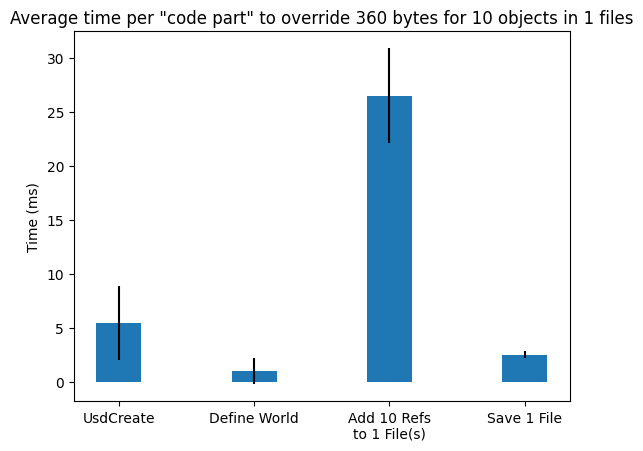

In [39]:
#Local variables to facilitate the access to the data
_nbRefs = nbRefs[0]
_nbBatch = nbBatch[0]
_usdExtension = usdExtension[0]
_totalBytesWritten = 3*3*4*_nbRefs
_key=(_totalBytesWritten, _nbRefs, _nbBatch, _usdExtension)

title = "Average time per \"code part\" to override {} bytes for {} objects in {} files".format(_totalBytesWritten, _nbRefs, _nbBatch)

plt.bar(np.arange(4)*30, averageTimingsMs[_key], 10, tick_label=allHeaders[_key], yerr = stdTimingsMs[_key])
plt.ylabel("Time (ms)")
plt.title(title)
plt.show()

### Plot All Data

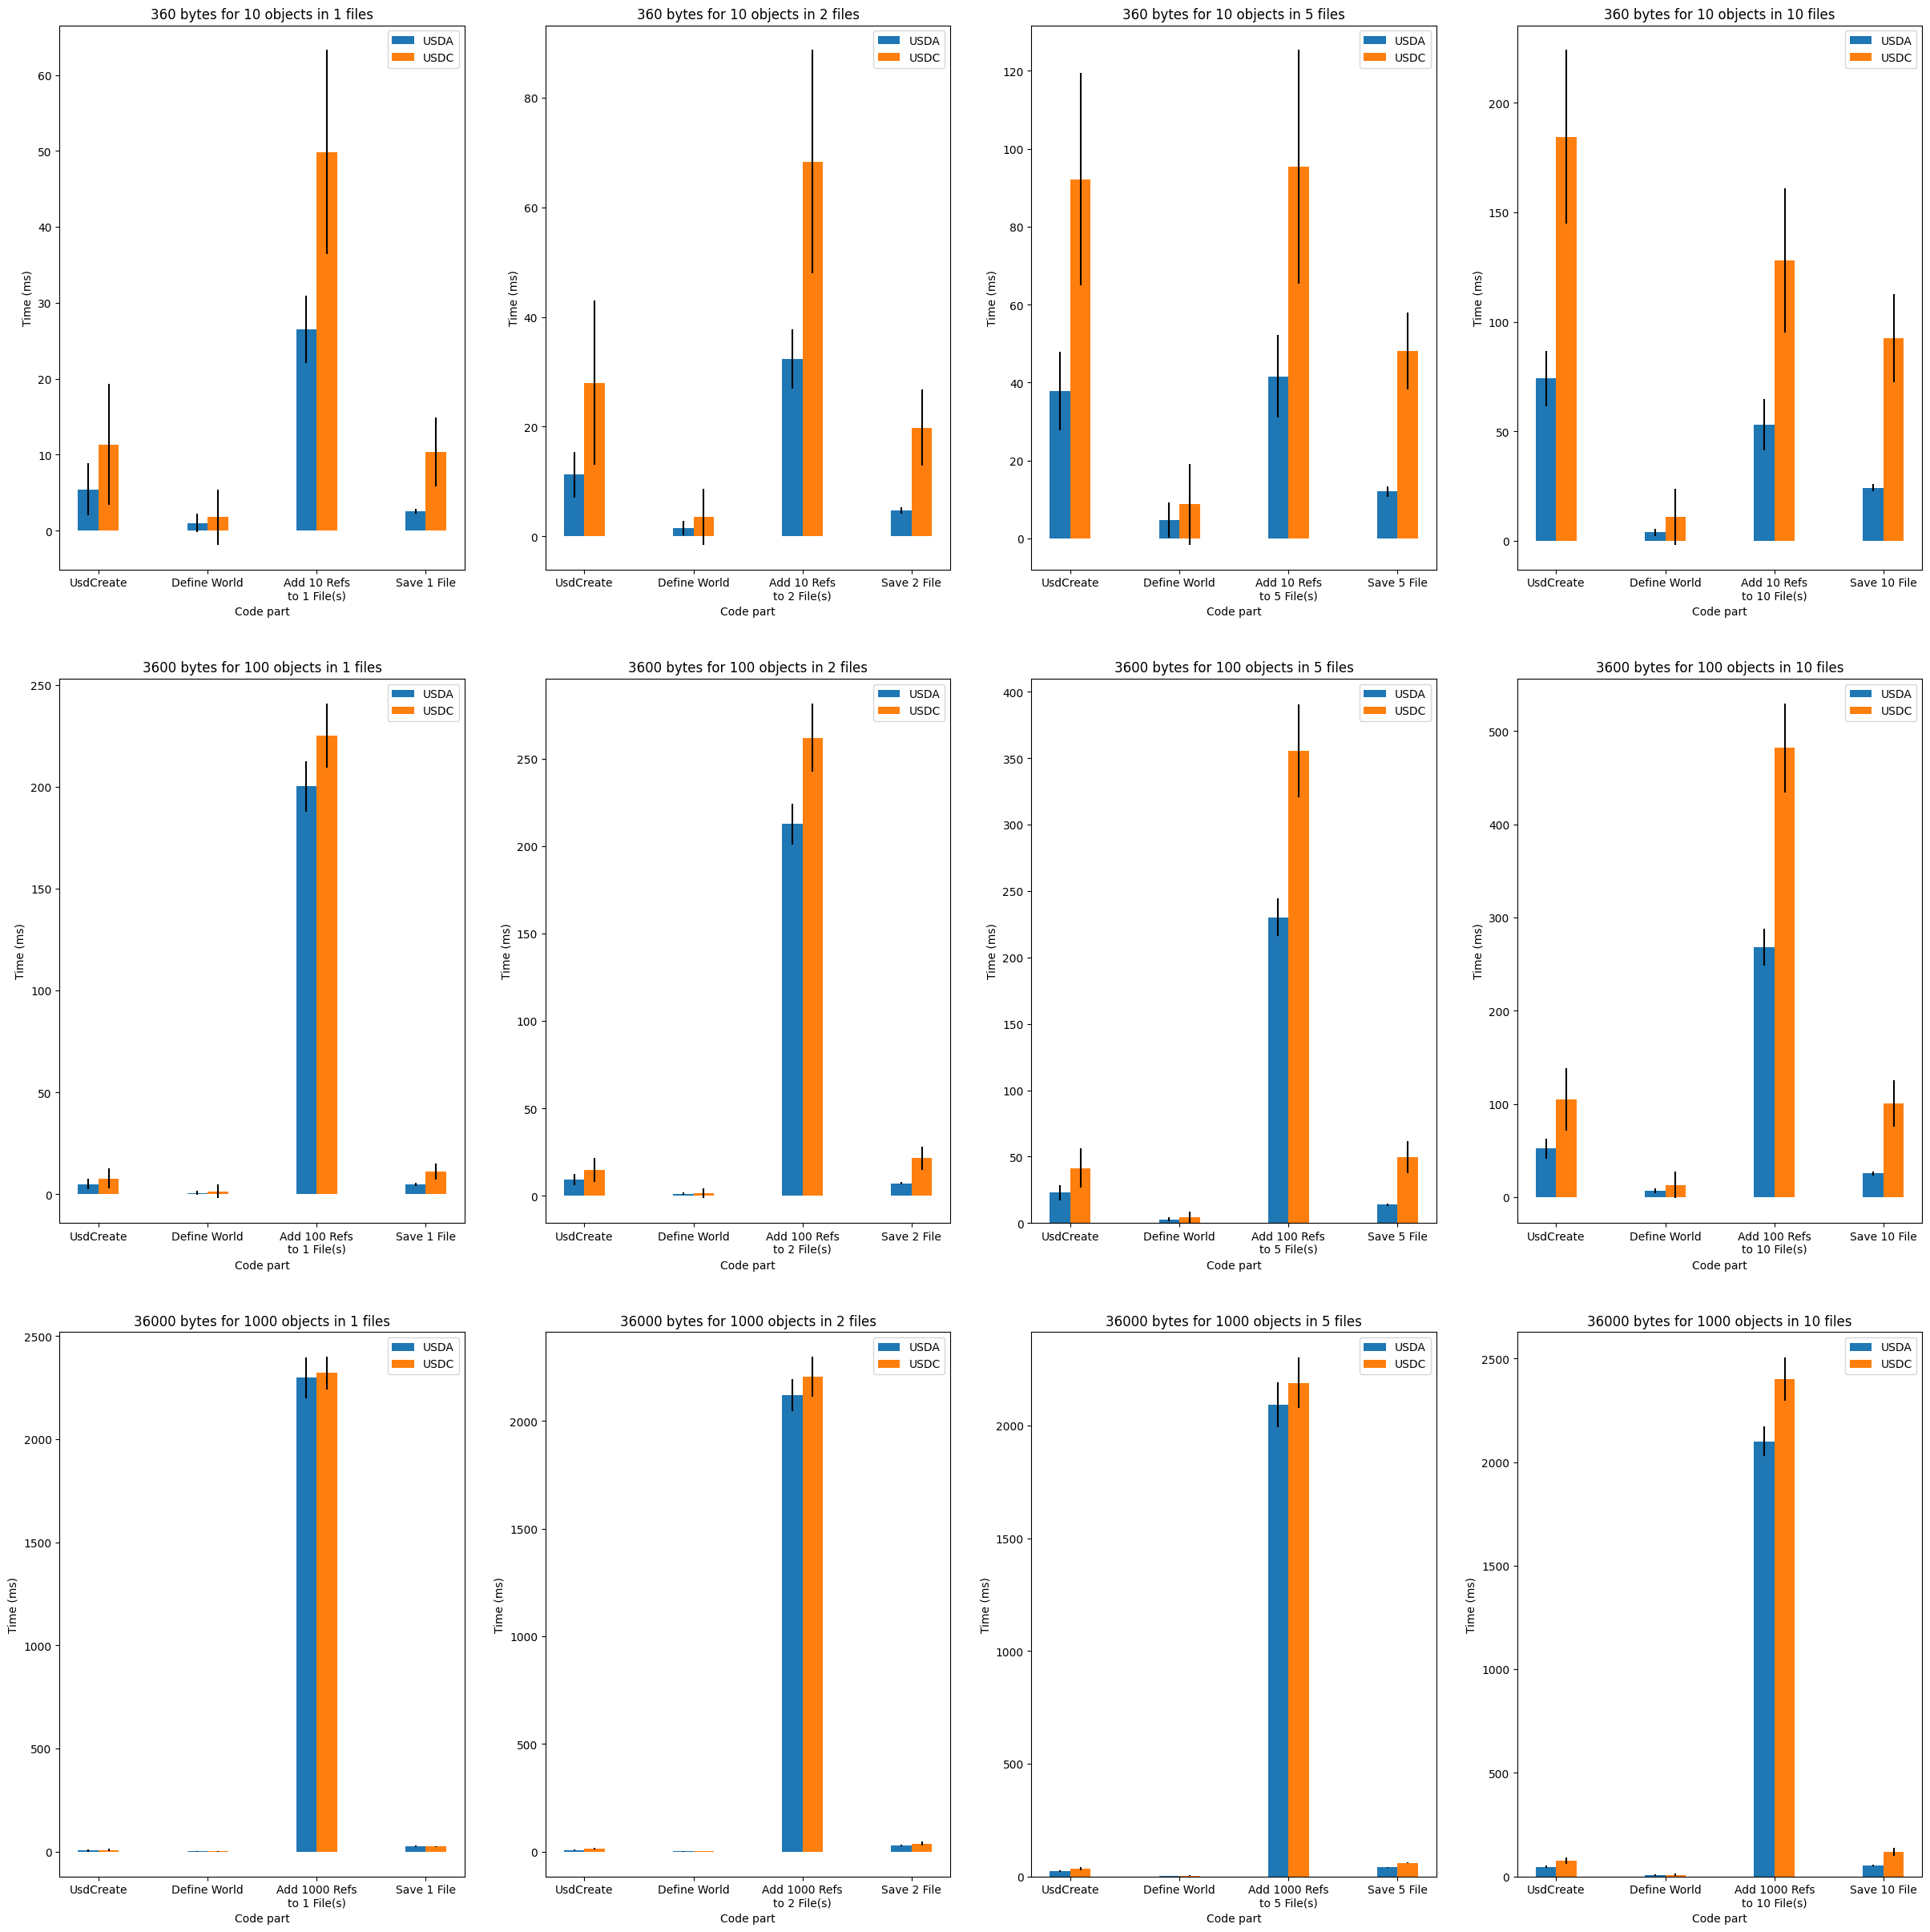

In [40]:
fig, axs = plt.subplots(len(nbRefs), len(nbBatch), figsize=(30, 30))
for i in range(len(nbRefs)):
    for j in range(len(nbBatch)):
        # Get the USDA and USDC keys for the current nbRefs value, usdExtension value, and nbBatch value
        keyUSDA = (3*3*4*nbRefs[i], nbRefs[i], nbBatch[j], usdExtension[0])
        keyUSDC = (3*3*4*nbRefs[i], nbRefs[i], nbBatch[j], usdExtension[1])
        # Set the title for the bar plot
        title = "{} bytes for {} objects in {} files".format(3*3*4*nbRefs[i], nbRefs[i], nbBatch[j])
        plot_multibar(axs[i,j],
                      np.arange(4)*30,
                      allHeaders[keyUSDA],
                      [averageTimingsMs[keyUSDA], averageTimingsMs[keyUSDC]],
                      [stdTimingsMs[keyUSDA], stdTimingsMs[keyUSDC]],
                      _plotTitle=title, _plotXLabel="Code part", _plotYLabel="Time (ms)", _dataLabels=["USDA", "USDC"])

## When is it worth it to batch references in files?

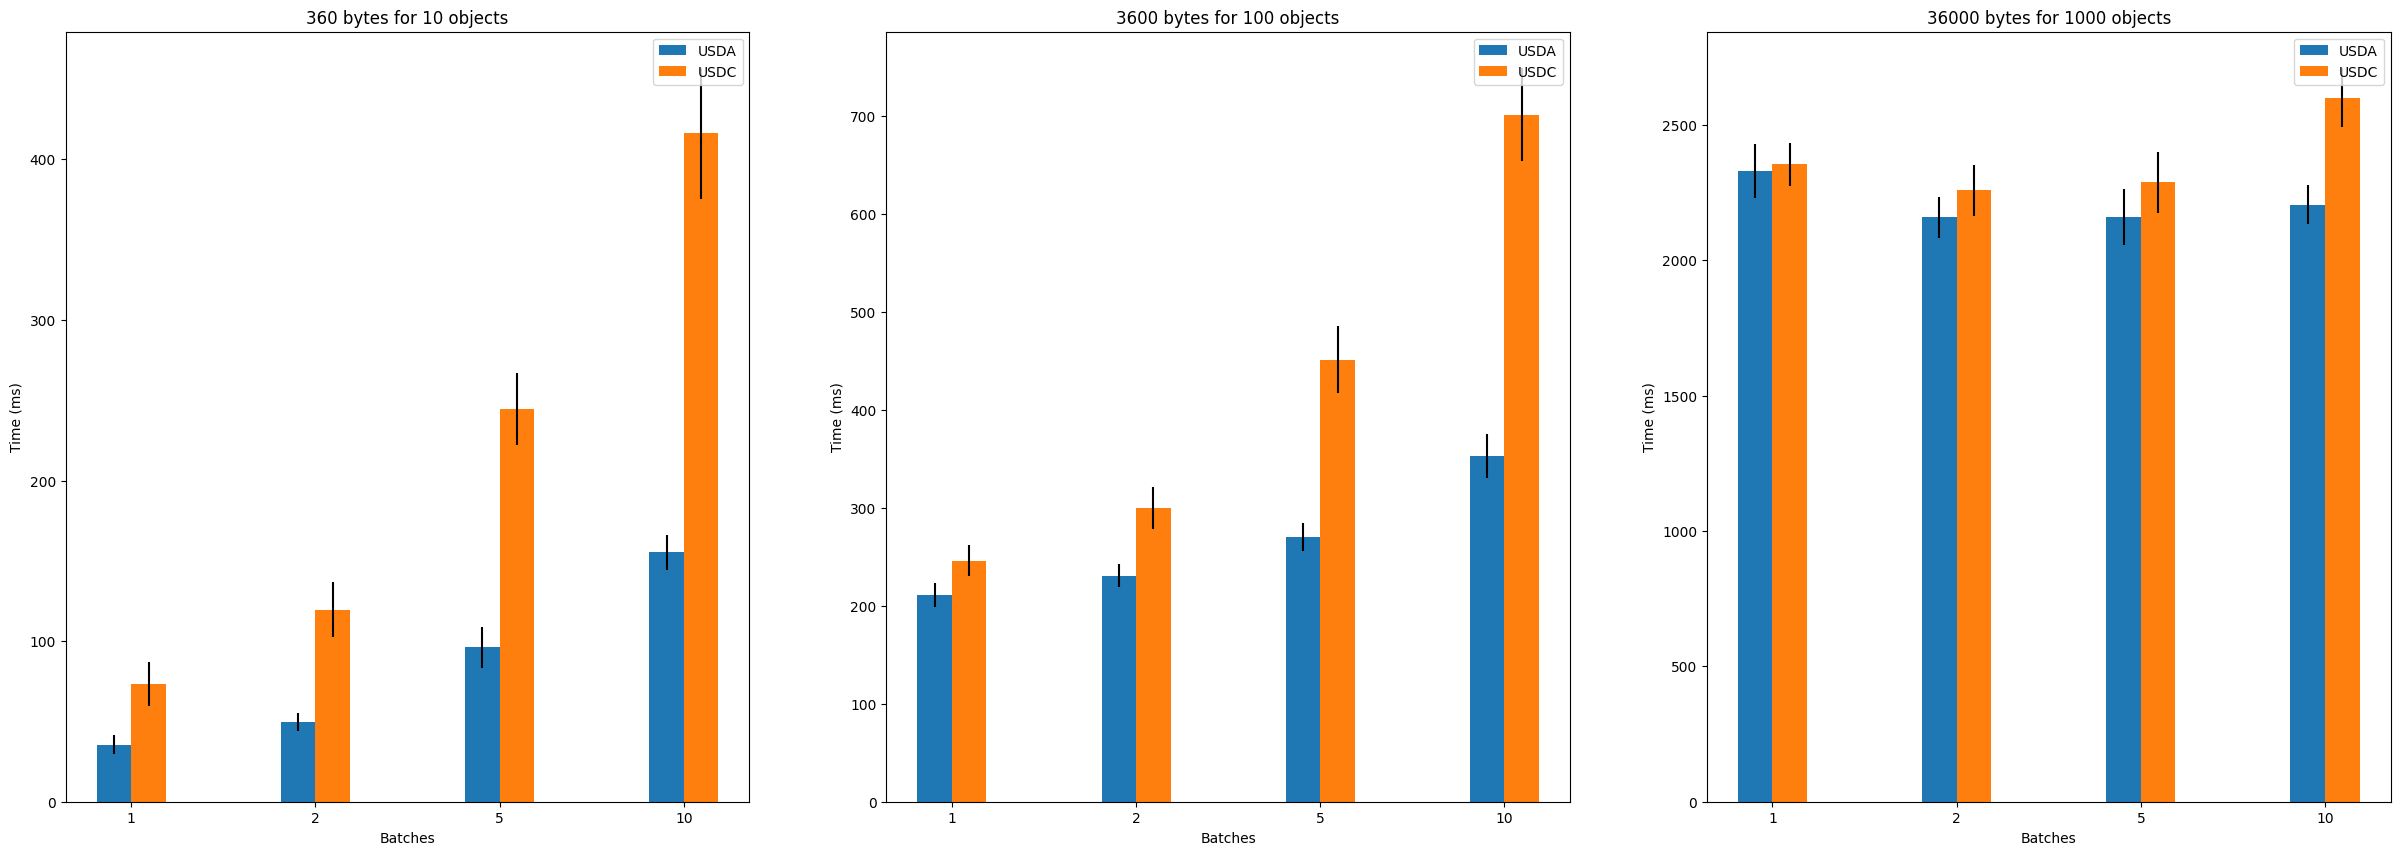

In [41]:
fig, axs = plt.subplots(1, len(nbRefs), figsize=(30,10))

for i in range(len(nbRefs)):

    # *2 to store both usda and usdc in a flat array
    batchAggregatedAverageTimingsMs = np.zeros(len(nbBatch)*2)
    batchAggregatedStdTimingsMs = np.zeros(len(nbBatch)*2) 

    for j in range(len(nbBatch)):
        # get the USDA and USDC keys to access the recorded timings
        _totalBytesWritten=3*3*4*nbRefs[i]
        keyUSDA = (_totalBytesWritten, nbRefs[i], nbBatch[j], usdExtension[0])
        keyUSDC = (_totalBytesWritten, nbRefs[i], nbBatch[j], usdExtension[1])

        # Aggregate the averaged total timings in single list to visualize within the same plot afterward.
        batchAggregatedAverageTimingsMs[j] = totalAverageTimingsMs[keyUSDA]
        batchAggregatedAverageTimingsMs[j+len(nbBatch)] = totalAverageTimingsMs[keyUSDC]
        batchAggregatedStdTimingsMs[j] = totalStdTimingsMs[keyUSDA]
        batchAggregatedStdTimingsMs[j+len(nbBatch)] = totalStdTimingsMs[keyUSDC]

    plot_multibar(axs[i],
                    np.arange(4)*30,
                    nbBatch,
                    [batchAggregatedAverageTimingsMs[:len(nbBatch)], batchAggregatedAverageTimingsMs[len(nbBatch):]],
                    [batchAggregatedStdTimingsMs[:len(nbBatch)], batchAggregatedStdTimingsMs[len(nbBatch):]],
                    _plotTitle="{} bytes for {} objects".format(_totalBytesWritten, nbRefs[i]),
                    _plotXLabel="Batches",
                    _plotYLabel="Time (ms)",
                    _dataLabels=["USDA", "USDC"])
                          
            

It starts being interresting to separate references into multiple files in the order of 1k objects.

## Is it worth multithreading the data generation?
What we want to compare here is the maximum time it takes to join all threads. We will estimate that (slightly underestimate) by the time that took the slowest thread to compute all its share of the repetitions. Because we know we cannot move on to the next part of the data generation unless the slowest has finished (as all threads almost all start at the same time).

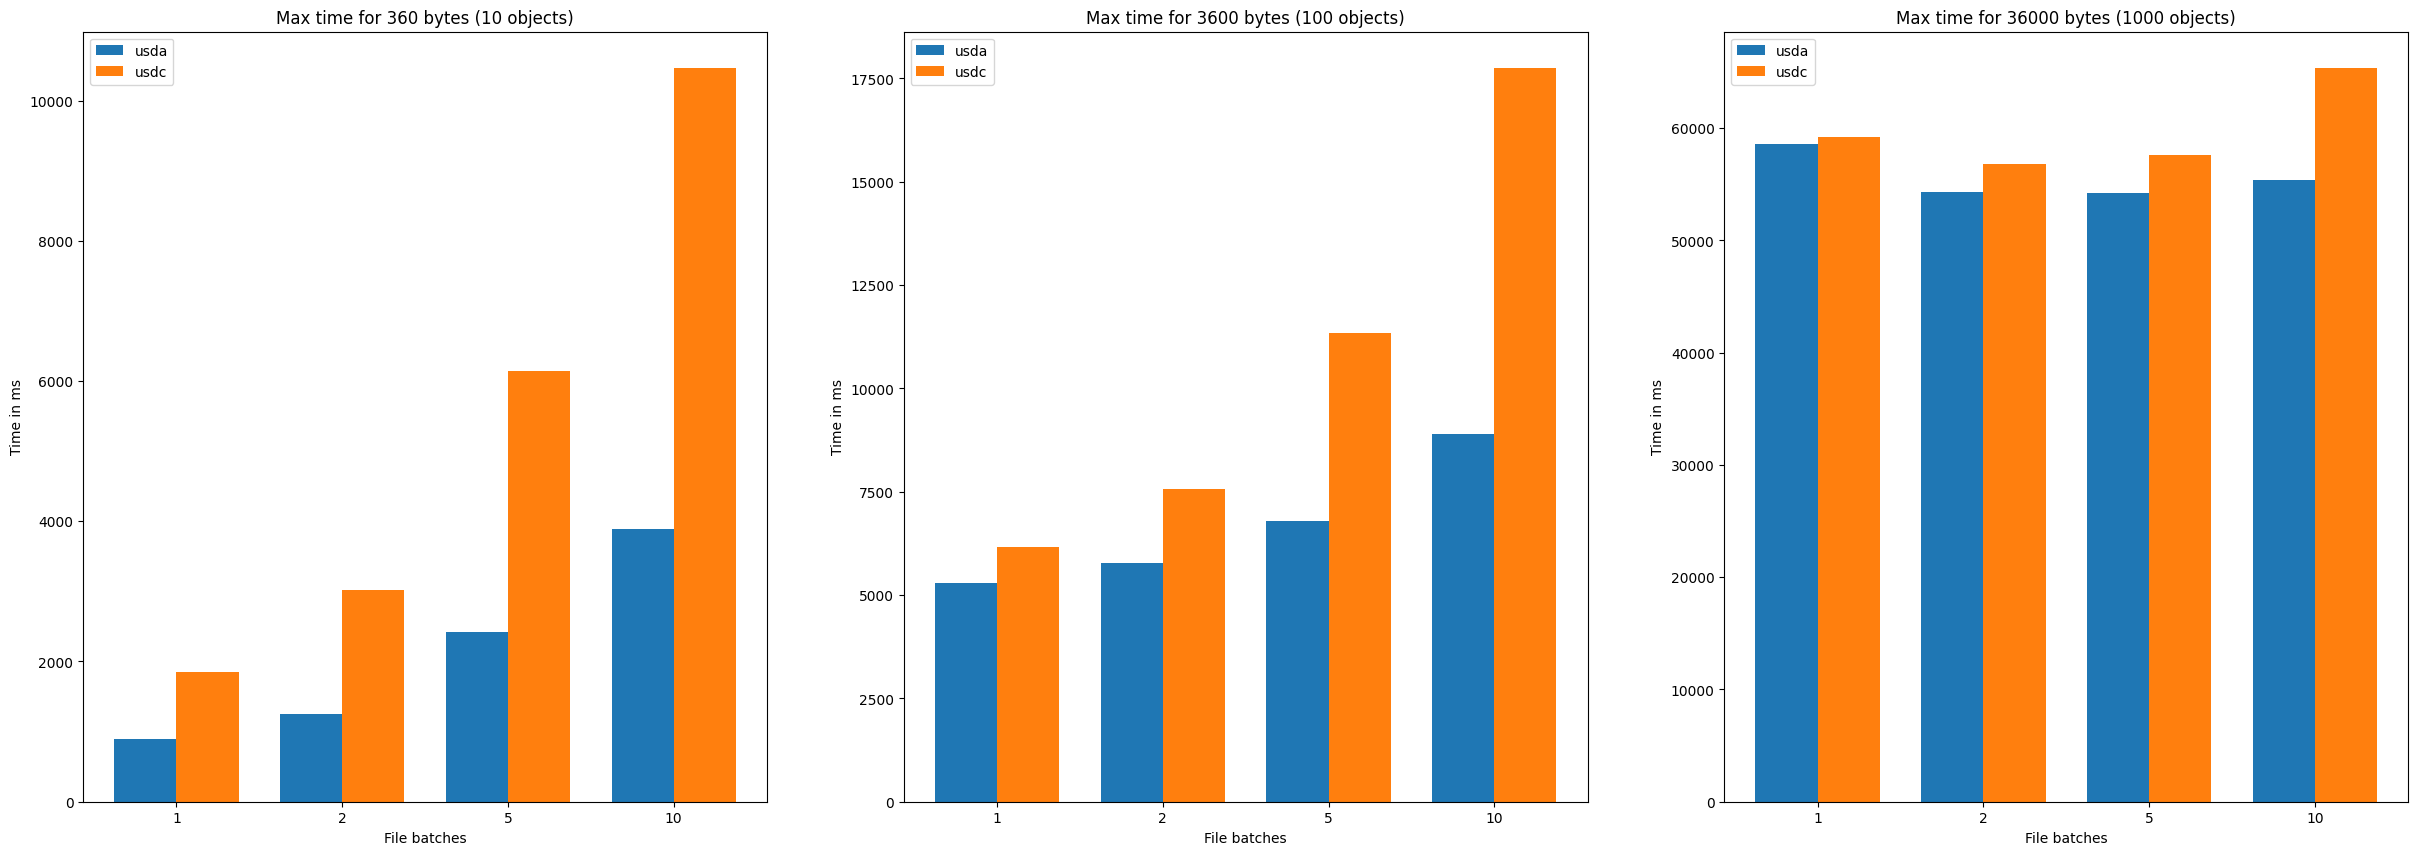

In [42]:
# Calculate the number of repetitions per thread
repsPerThread = nbRepeats // numThreadUsedForGen
endRepsIndeces = []
for i in range(numThreadUsedForGen):
    start_rep = i * repsPerThread
    end_rep = start_rep + repsPerThread if i < numThreadUsedForGen - 1 else nbRepeats
    endRepsIndeces += [end_rep]

nbSections = len(endRepsIndeces)

maxThreadTimes = np.zeros(len(allData))

i = 0
for key, val in allData.items():
    #we know the data generated by different threads are in order in the arrays
    #so we only need to separate the arrays by the number of repetitions handled by each thread.
    temp = np.split(val, endRepsIndeces) 
    #we sum all the time it takes to complete each thread and take the slowest (i.e. max time)
    maxThreadTimes[i] = NanoToMilli(max([np.sum(temp[i]) for i in range(nbSections)]))
    i += 1
    

maxThreadTimesPerNbRefs = np.split(maxThreadTimes, 3)


# Base x-axis positions for the bars
xBase=np.arange(len(nbBatch))*30
# Set the width of the bars
bar_width = max(xBase) / (len(xBase) * 2)
# Adapt the positions based on the width
x_positions = np.array(xBase) - bar_width/2

fig, axs = plt.subplots(1, len(nbRefs), figsize=(30,10))
for i in range(len(nbRefs)):
    for k in range(0, len(usdExtension)):
        y=[]
        for j in range(0, len(nbBatch)):
            y.append(maxThreadTimesPerNbRefs[i][j*len(usdExtension)+k])
        
        axs[i].bar(x_positions+k*bar_width, y, label=usdExtension[k], width=bar_width)

    # Customize the plot
    axs[i].set_xlabel("File batches")
    axs[i].set_ylabel("Time in ms")
    axs[i].set_title("Max time for {} bytes ({} objects)".format(3*3*4*nbRefs[i], nbRefs[i]))

        # Set the x tick labels
    axs[i].set_xticks(x_positions+0.5*(len(usdExtension)-1)*bar_width)
    axs[i].set_xticklabels(nbBatch)

    axs[i].legend()